<a href="https://colab.research.google.com/github/Aniruddha18-SPD/Multilingual-Sentiment-Analysis-with-Fine-tuned-Bidirectional-Encoder-Representations-from-Transfor/blob/main/CS_II_G_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Drive to Import files from Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/XTechHBCU/combined_tsv.tsv"

'/content/drive/My Drive/XTechHBCU/combined_tsv.tsv'


#2. Installing Transformers Library 

In [ ]:
!pip install transformers

In [ ]:
import os
import re
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast

import time
from babel.dates import format_date, format_datetime, format_time

%matplotlib inline
device = torch.device("cuda")


#3. Loading Dataset

In [ ]:
#Function to determine overall sentiment based on existing labels
def determineOverall(arr) -> int:
  res = 0
  positive = {5}
  negative = {1, 3, 4, 6}
  neutral = {0, 2, 7, 8}
  for num in arr:
    if num in positive:
      res += 1
    elif num in negative:
      res -= 1
    elif num in neutral:
      res += 0
  if res > 0:
    return 2
  elif res < 0:
    return 1
  elif res  == 0:
    return 0  

#converting the array of strings to ints
def convArr(arr):
  # print(arr)
  stoi = lambda x: int(x)
  for i in range(len(arr)):
    arr[i] = stoi(arr[i])
  

In [ ]:
#reading the dataset
col_list = ["Subtitle", "Labels","Language"]  #three columns seperating the dialouges, language and its emotions (emotions numbered from 1 to 8 according to  Plutchik emotions )
df = pd.read_csv("/content/combined_tsv (1).tsv",sep="\t", usecols=col_list)


newLst = [] # build newLst with above function
count = 0
#print(df.tail())
df = df.drop(index=164453)  #weird text causing convArr to fail
for ind in df.index:
  a = df["Labels"][ind]
  b = a.split(", ")
  convArr(b)
  res = determineOverall(b)
  newLst.append(res)
  
df["Overall"] = newLst
df = df.dropna()
df.sample(5)

,Subtitle,Labels,Language,Overall
21763,"Olha, foi muito bom ver você de novo, ok? Eu só -",6,br,1
73570,Oletko ihminen?,2,fi,0
64551,"En otras palabras, estos tipos tienen que abri...",1,es,1
57252,¡Bueno esta es la 31!,5,es,2
150229,Pažljivo gledaj.,5,sr,2


#4. Splitting Dataset for Training, Validation and Testing

In [ ]:
#splitting into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df["Subtitle"], df["Overall"], random_state=2018, test_size=0.2, stratify=df["Overall"])
# df.groupby(['year', 'month', 'class']).size()
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.2, stratify=temp_labels)

#5. Importing BERT Model and BERT Tokenizer

In [ ]:
bert = AutoModel.from_pretrained('bert-base-multilingual-cased')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#6. Tokenization

In [ ]:
seq_len = [len(i.split()) for i in train_text]
actual_max_seq_len = int(max(seq_len))
print(len(seq_len), actual_max_seq_len)
max_seq_len = 64
# pd.Series(seq_len).hist(bins='auto')


140693 61


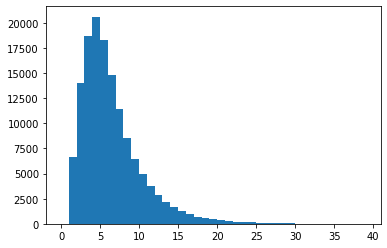

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(tokens_train, bin = 'auto')
# %matplotlib inline
# plt.hist(seq_len, bins=np.arange(min(seq_len), max(seq_len) + binwidth, binwidth))
# binwidth = 
# plt.hist(seq_len, bins=range(min(seq_len), max(seq_len) + binwidth, binwidth))
# plt.hist(seq_len, bins = 'auto')
plt.hist(seq_len, bins=range(0,40))
# plt.hist(train_text)
plt.show(); 

In [ ]:
#tokenizing and encoding sequences in training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

#tokenizing and encoding sequences in validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

#tokenizing and encoding sequences in test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

#7. Converting Interger Sequences to Tensors

In [ ]:
#converting integer sequences to tensors
#for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.to_list())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())



#8. Creating Data Loaders

In [ ]:
#Creating Dataloaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_data = TensorDataset(train_seq, train_mask, train_y) #wrapping tensors

train_sampler = RandomSampler(train_data) #sampler for sampling the data during training

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) #dataLoader for train set

val_data = TensorDataset(val_seq, val_mask, val_y) #wrapping tensors

val_sampler = SequentialSampler(val_data) #sampler for sampling the data during training

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size) #dataLoader for validation set



#9. Freezing BERT Parameters

In [ ]:
#Freezing bert parameters
for param in bert.parameters():
    param.requires_grad = False

#10. Defining Model Architecture

In [ ]:
#Defining model architecture
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,64)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(64,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# passing the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# # pushing the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

#11. Finding Class Weights

In [ ]:
#Finding class weights
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
    )
print(class_wts)

[1.08418871 0.61801785 2.17592292]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 7

#12. Fine-Tuning BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  t0 = time.time()
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

#13. Starting Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


  Batch    50  of  17,587.
  Batch   100  of  17,587.
  Batch   150  of  17,587.
  Batch   200  of  17,587.
  Batch   250  of  17,587.
  Batch   300  of  17,587.
  Batch   350  of  17,587.
  Batch   400  of  17,587.
  Batch   450  of  17,587.
  Batch   500  of  17,587.
  Batch   550  of  17,587.
  Batch   600  of  17,587.
  Batch   650  of  17,587.
  Batch   700  of  17,587.
  Batch   750  of  17,587.
  Batch   800  of  17,587.
  Batch   850  of  17,587.
  Batch   900  of  17,587.
  Batch   950  of  17,587.
  Batch 1,000  of  17,587.
  Batch 1,050  of  17,587.
  Batch 1,100  of  17,587.
  Batch 1,150  of  17,587.
  Batch 1,200  of  17,587.
  Batch 1,250  of  17,587.
  Batch 1,300  of  17,587.
  Batch 1,350  of  17,587.
  Batch 1,400  of  17,587.
  Batch 1,450  of  17,587.
  Batch 1,500  of  17,587.
  Batch 1,550  of  17,587.
  Batch 1,600  of  17,587.
  Batch 1,650  of  17,587.
  Batch 1,700  of  17,587.
  Batch 1,750  of  17,587.
  Batch 1,800  of  17,587.
  Batch 1,850  of  17,587.
 

KeyboardInterrupt: ignored

#14. Loading Saved Model

In [ ]:
#load weights of best model
path = './saved_weights.pt'
model.load_state_dict(torch.load(path))

FileNotFoundError: ignored

#15. Getting Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)